In [ ]:
%pip install google-colab
%pip install gdown

# Import the drive module from google.colab
from google.colab import drive

# Mount Google Drive
drive.mount('/content/drive')

Note: you may need to restart the kernel to use updated packages.


ERROR: Could not find a version that satisfies the requirement google-colab (from versions: none)
ERROR: No matching distribution found for google-colab


Note: you may need to restart the kernel to use updated packages.
The 'google.colab' module is not available outside Google Colab.


In [ ]:
import json

# Define the correct path to your metadata file in Google Drive
metadata_path = "caltech_images_20210113.json"

In [ ]:
# Load JSON metadata from Drive
with open(metadata_path, "r") as f:
    metadata = json.load(f)


In [ ]:
# Extract all unique category names from metadata
all_labels = set()

for category in metadata["categories"]:
    all_labels.add(category["name"])

# Convert set to a sorted list
all_labels = sorted(list(all_labels))

print(f"✅ Found {len(all_labels)} unique labels:")
print(all_labels)


✅ Found 22 unique labels:
['badger', 'bat', 'bird', 'bobcat', 'car', 'cat', 'cow', 'coyote', 'deer', 'dog', 'empty', 'fox', 'insect', 'lizard', 'mountain_lion', 'opossum', 'pig', 'rabbit', 'raccoon', 'rodent', 'skunk', 'squirrel']


In [ ]:
import random

unique_file_names = set(image["file_name"] for image in metadata["images"])
num_unique_file_names = len(unique_file_names)

def random_file_name(metadata):
  random_nb = random.randint(0, num_unique_file_names - 1)
  random_file_name = metadata["images"][random_nb]["file_name"]
  return random_file_name

In [ ]:
# Precompute a mapping from category_id to category_name
category_map = {cat['id']: cat['name'] for cat in metadata['categories']}

# Precompute a mapping from image_id to category_id
# (Assuming each image has one annotation. Adjust if multiple annotations are needed.)
annotation_map = {}
for annotation in metadata['annotations']:
    # If there are multiple annotations per image, decide on a strategy (e.g., first occurrence)
    if annotation['image_id'] not in annotation_map:
        annotation_map[annotation['image_id']] = annotation['category_id']

# Build the image label map using constant-time lookups
image_label_map = {}
for image in metadata['images']:
    image_id = image['id']
    category_id = annotation_map.get(image_id)
    category_name = category_map.get(category_id, 'Unknown')  # default if not found
    image_label_map[image['file_name']] = category_name

print(list(image_label_map.items())[:5])

[('5968c0f9-23d2-11e8-a6a3-ec086b02610b.jpg', 'empty'), ('5a0b016f-23d2-11e8-a6a3-ec086b02610b.jpg', 'deer'), ('59b93afb-23d2-11e8-a6a3-ec086b02610b.jpg', 'cat'), ('59641f56-23d2-11e8-a6a3-ec086b02610b.jpg', 'opossum'), ('5a1e5306-23d2-11e8-a6a3-ec086b02610b.jpg', 'empty')]


In [ ]:
label_to_index = {label: index for index, label in enumerate(all_labels)}
print("Label to index map:")
label_to_index


Label to index map:


{'badger': 0,
 'bat': 1,
 'bird': 2,
 'bobcat': 3,
 'car': 4,
 'cat': 5,
 'cow': 6,
 'coyote': 7,
 'deer': 8,
 'dog': 9,
 'empty': 10,
 'fox': 11,
 'insect': 12,
 'lizard': 13,
 'mountain_lion': 14,
 'opossum': 15,
 'pig': 16,
 'rabbit': 17,
 'raccoon': 18,
 'rodent': 19,
 'skunk': 20,
 'squirrel': 21}

In [ ]:
# Step 4: Create a mapping from image filename to index
image_index_map = {}
for filename, label in image_label_map.items():
    index = label_to_index.get(label)
    if index is not None:
        image_index_map[filename] = index

# Print some examples
print("Example image filename to index map:")
print(list(image_index_map.items())[:5])


Example image filename to index map:
[('5968c0f9-23d2-11e8-a6a3-ec086b02610b.jpg', 10), ('5a0b016f-23d2-11e8-a6a3-ec086b02610b.jpg', 8), ('59b93afb-23d2-11e8-a6a3-ec086b02610b.jpg', 5), ('59641f56-23d2-11e8-a6a3-ec086b02610b.jpg', 15), ('5a1e5306-23d2-11e8-a6a3-ec086b02610b.jpg', 10)]


In [ ]:
# Define file path for images
path = 'https://lilawildlife.blob.core.windows.net/lila-wildlife/caltech-unzipped/cct_images/'


In [ ]:
from transformers import AutoProcessor, AutoModel
import requests
from pathlib import Path

if not Path("notebook_utils.py").exists():
    r = requests.get(
        url="https://raw.githubusercontent.com/openvinotoolkit/openvino_notebooks/latest/utils/notebook_utils.py",
    )
    open("notebook_utils.py", "w").write(r.text)

# Read more about telemetry collection at https://github.com/openvinotoolkit/openvino_notebooks?tab=readme-ov-file#-telemetry
from notebook_utils import collect_telemetry

collect_telemetry("siglip-zero-shot-image-classification.ipynb")

model = AutoModel.from_pretrained("google/siglip-base-patch16-224")
processor = AutoProcessor.from_pretrained("google/siglip-base-patch16-224")

In [ ]:
# Results visualization function
from typing import List
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image


def visualize_result(image: Image, labels: List[str], probs: np.ndarray, top: int = 5):
    """
    Utility function for visualization classification results
    params:
      image: input image
      labels: list of classification labels
      probs: model predicted softmaxed probabilities for each label
      top: number of the highest probability results for visualization
    returns:
      None
    """
    plt.figure(figsize=(72, 64))
    top_labels = np.argsort(-probs)[: min(top, probs.shape[0])]
    top_probs = probs[top_labels]
    plt.subplot(8, 8, 1)
    plt.imshow(image)
    plt.axis("off")

    plt.subplot(8, 8, 2)
    y = np.arange(top_probs.shape[-1])
    plt.grid()
    plt.barh(y, top_probs)
    plt.gca().invert_yaxis()
    plt.gca().set_axisbelow(True)
    plt.yticks(y, [labels[index] for index in top_labels])
    plt.xlabel("probability")

    print([{labels[x]: round(y, 2)} for x, y in zip(top_labels, top_probs)])

59817cb7-23d2-11e8-a6a3-ec086b02610b.jpg
https://lilawildlife.blob.core.windows.net/lila-wildlife/caltech-unzipped/cct_images/59817cb7-23d2-11e8-a6a3-ec086b02610b.jpg


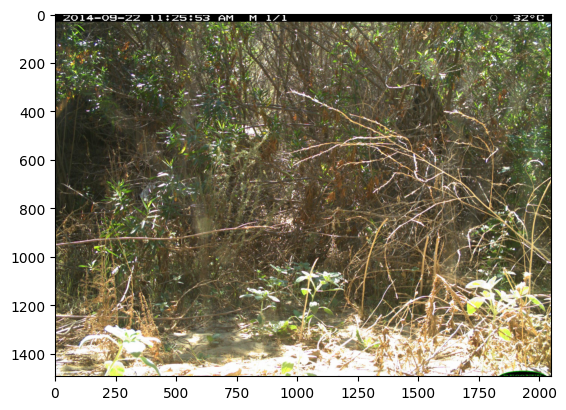

In [ ]:
import requests
from pathlib import Path
import torch
from PIL import Image

image_path = Path(random_file_name(metadata))

print(image_path)

print(path+str(image_path))

if not image_path.exists():
    r = requests.get(
        path+str(image_path),
    )
    with image_path.open("wb") as f:
        f.write(r.content)
image = Image.open(image_path)
plt.imshow(image)
plt.show()



Predicted Label: opossum
Real Label: empty
[{'opossum': 0.24}, {'raccoon': 0.11}, {'mountain_lion': 0.11}, {'rabbit': 0.07}, {'bobcat': 0.07}]


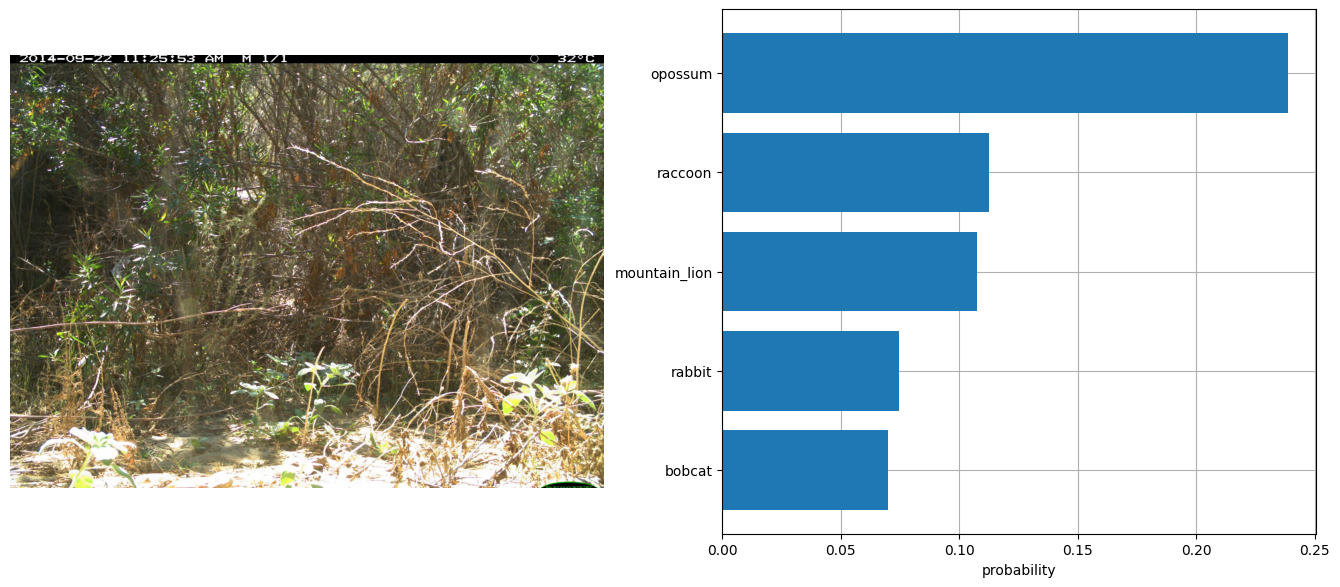

In [ ]:
import requests
from pathlib import Path
import torch
from PIL import Image

text_descriptions = [f"a trap camera picture of {label}" for label in all_labels]

inputs = processor(text=text_descriptions, images=[image], padding="max_length", return_tensors="pt")

with torch.no_grad():
    model.config.torchscript = False
    results = model(**inputs)

logits_per_image = results["logits_per_image"]  # this is the image-text similarity score

# Calculate probabilities using softmax
probs = logits_per_image.softmax(dim=1).detach().numpy() # This line is added


# Find the predicted label with the highest probability
predicted_label_index = np.argmax(probs[0])
predicted_label = all_labels[predicted_label_index]

print(f"\nPredicted Label: {predicted_label}")
print(f"Real Label: {image_label_map.get(str(image_path))}")

visualize_result(image, all_labels, probs[0])


In [ ]:
def predict_image_label(image, model, processor, all_labels):
    if image is None:
        return "empty"
    
    text_descriptions = [f"This is a photo of a {label}" for label in all_labels]
    inputs = processor(text=text_descriptions, images=[image], padding="max_length", return_tensors="pt")
    with torch.no_grad():
        model.config.torchscript = False
        results = model(**inputs)
    logits_per_image = results["logits_per_image"]
    probs = logits_per_image.softmax(dim=1).detach().numpy()
    predicted_label_index = np.argmax(probs[0])
    predicted_label = all_labels[predicted_label_index]
    return predicted_label


In [ ]:
from megadetector.utils import url_utils
from megadetector.visualization import visualization_utils as vis_utils
from megadetector.detection import run_detector
import tempfile

# This will automatically download MDv5a; you can also specify a filename.
detector_model = run_detector.load_detector('md_v5a.0.0.pt')

result = detector_model.generate_detections_one_image(image)

detections_above_threshold = [d for d in result['detections'] if d['conf'] > 0.2]
print('Found {} detections above threshold'.format(len(detections_above_threshold)))

# This will display the image with the detections overlaid
cropped_images = vis_utils.crop_image(detections_above_threshold, image, confidence_threshold=0.2, expansion=10)


# Create a temp file for the predict image label image
temp_file = None
if cropped_images:
    temp_file = tempfile.NamedTemporaryFile(delete=False, suffix=".jpg")
    cropped_images[0].save(temp_file.name)

predicted_label = predict_image_label(temp_file.name if temp_file else None, model, processor, all_labels)
print(f"Predicted Label: {predicted_label}")

# Clean up the temp file
if temp_file:
    temp_file.close()
    Path(temp_file.name).unlink()


Bypassing imports for model type yolov5
Loading PT detector with compatibility mode classic


Fusing layers... 
Fusing layers... 
Model summary: 733 layers, 140054656 parameters, 0 gradients, 208.8 GFLOPs
Model summary: 733 layers, 140054656 parameters, 0 gradients, 208.8 GFLOPs


Found 0 detections above threshold
Predicted Label: empty


In [ ]:
def crop_image_with_megadetector(image, detector_model):
    """
    Function to crop the image using MegaDetector and return the first cropped image or None if no detection.
    params:
      image: input image
      detector_model: loaded MegaDetector model
    returns:
      cropped_image: the first cropped image or None if no detection
    """
    result = detector_model.generate_detections_one_image(image)
    detections_above_threshold = [d for d in result['detections'] if d['conf'] > 0.2]
    
    if detections_above_threshold:
        cropped_images = vis_utils.crop_image(detections_above_threshold, image, confidence_threshold=0.2, expansion=10)
        return cropped_images[0] if cropped_images else None
    else:
        return None

In [ ]:
correct_predictions = 0
num_samples = 10

for _ in range(num_samples):
    # Get a random file name
    random_filename = random_file_name(metadata)
    
    # Load the image
    image_path = Path(random_filename)
    if not image_path.exists():
        r = requests.get(path + str(image_path))
        with image_path.open("wb") as f:
            f.write(r.content)
    image = Image.open(image_path)
    
    # Crop the image using MegaDetector
    cropped_image = crop_image_with_megadetector(image, detector_model)
    
    # Predict the label
    predicted_label = predict_image_label(cropped_image if cropped_image else None, model, processor, all_labels)
    
    # Get the true label
    true_label = image_label_map.get(str(image_path), 'Unknown')
    
    # Print the predicted and true label
    print(f"Predicted Label: {predicted_label}, True Label: {true_label}")

    # Check if the prediction is correct
    if predicted_label == true_label:
        correct_predictions += 1

accuracy = correct_predictions / num_samples
print(f"Accuracy over {num_samples} random images: {accuracy * 100:.2f}%")




Predicted Label: dog, True Label: dog
Predicted Label: coyote, True Label: coyote
Predicted Label: empty, True Label: bird
Predicted Label: bat, True Label: empty
Predicted Label: empty, True Label: empty
Predicted Label: empty, True Label: empty
Predicted Label: empty, True Label: empty
Predicted Label: rabbit, True Label: rabbit
Predicted Label: squirrel, True Label: squirrel
Predicted Label: bird, True Label: bird
Accuracy over 10 random images: 80.00%


In [ ]:
import dash
from dash import dcc, html
from dash.dependencies import Input, Output, State
import dash_bootstrap_components as dbc
import base64
import io
from PIL import Image
import tempfile

# Initialize the Dash app
app = dash.Dash(__name__, external_stylesheets=[dbc.themes.MINTY])

left_card = dbc.Card(
    [
        dbc.CardBody(
            [
                html.H4("Original image", className="left_card", style={'textAlign': 'center'}),
                dbc.CardImg(children=None, top=True, id="original_image", style={'textAlign': 'center', 'borderRadius': '5px', 'height': '300px', 'width':'auto', 'textAlign': 'center'}),
                html.P(
                    "You should upload an image.",
                    className="card-text",
                    id="original_image_text",
                ),
            dbc.Button("Detect Animals !", color="primary", id="left_card_button"),
            ]
        ),
    ],
    style={"width": "auto", "textAlign": "center", 'background' : '#88E788'},
)

right_card = dbc.Card(
    [ 
        dbc.CardBody(
            [
                html.H4("Cropped image", className="right_card", style={'textAlign': 'center'}),
                dbc.CardImg(children=None, top=True, id="cropped_image", style={'textAlign': 'center', 'borderRadius': '5px', 'height': '300px', 'width': 'auto', 'textAlign': 'center'}),
                html.P(
                    "First upload an image to see the cropped image.",
                    className="card-text",
                    id="cropped_image_text",
                ),
            ],
            style={'textAlign': 'center'}
        ),
    ],
    style={"width": "auto", 'background' : '#88E788'},
)

# Define the layout of the app
app.layout = dbc.Container([
    
    dbc.Row([
        html.Br(),
        dbc.Col(html.H1("Camera Trap Image Classifier", style={'textAlign': 'center', 'background' : '#88E788'})),
        html.Br(),
    ], justify='center'),
    html.Br(),
    dbc.Row([
        dbc.Col([
            dcc.Upload(
                id='upload-image',
                children=html.Div([
                    'Drag and Drop or ',
                    html.A('Select an Image')
                ]),
                style={
                    'width': '30%',
                    'height': '60px',
                    'lineHeight': '60px',
                    'borderWidth': '1px',
                    'borderStyle': 'dashed',
                    'borderRadius': '5px',
                    'textAlign': 'center',
                    'margin': 'auto'
                },
            ),
        ],),
    ], justify='center'),
    html.Br(),
    dbc.Col([
        dbc.Row([
            dbc.Col(left_card, width=6),
            dbc.Col(right_card, width=6),
        ]),
    ]),
    html.Br(),
    html.Br(),
    html.Br(),
    html.Br(),
    html.Br(),
    html.Br(),
    html.Br(),
    html.Br(),
    html.Br(),
    ],
    fluid=True,
    style={'background': '#D4F6D4'}
)

@app.callback(
    Output("original_image", "src"),
    Output("original_image_text", "children"),
    Input("upload-image", "contents")
)
def update_original_image(contents):
    if contents is not None:
        content_type, content_string = contents.split(",")
        decoded = base64.b64decode(content_string)
        image = Image.open(io.BytesIO(decoded))
        image.save("original_image.jpg")
        return contents, "Press the button to detect animals."
    return None, "You should upload an image."

@app.callback(
    Output("cropped_image", "src"),
    Output("cropped_image_text", "children"),
    Input("upload-image", "contents"),
    Input("left_card_button", "n_clicks"),
    State("upload-image", "contents")
)
def update_cropped_image(contents, n_clicks, state_contents):
    if contents is not None and n_clicks is not None:
        content_type, content_string = contents.split(",")
        decoded = base64.b64decode(content_string)
        image = Image.open(io.BytesIO(decoded))
        
        # Crop the image using MegaDetector
        cropped_image = crop_image_with_megadetector(image, detector_model)
        
        if cropped_image:
            temp_file = tempfile.NamedTemporaryFile(delete=False, suffix=".jpg")
            cropped_image.save(temp_file.name)
            encoded_cropped_image = base64.b64encode(temp_file.read()).decode('utf-8')
            temp_file.close()

            # Predict the label
            predicted_label = predict_image_label(cropped_image, model, processor, all_labels)

            return f"data:image/jpeg;base64,{encoded_cropped_image}", "This is a camera trap image of a " + predicted_label + "."
        else:
            return None, "No animals detected in the image."
    return None, "First upload an image to see the cropped image."



if __name__ == '__main__':
    app.run_server(debug=True)
dash.register_page(__name__)

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/dash/dash.py:2282: DeprecationWarning:

Dash.run_server is deprecated and will be removed in Dash 3.0

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/dash/dash.py:1814: DeprecationWarning:

'pkgutil.find_loader' is deprecated and slated for removal in Python 3.14; use importlib.util.find_spec() instead

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/dash/dash.py:1814: DeprecationWarning:

'pkgutil.find_loader' is deprecated and slated for removal in Python 3.14; use importlib.util.find_spec() instead

